In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tabulate import tabulate
import fbprophet
#import warnings

from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from time import time
#import timeit

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('household_power_consumption.txt', delimiter = ';', header = 0, index_col=False)

C:\Users\lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [4]:
df = df[['Date','Time','Voltage']]

In [5]:
df

,Date,Time,Voltage
0,16/12/2006,17:24:00,234.840
1,16/12/2006,17:25:00,233.630
2,16/12/2006,17:26:00,233.290
3,16/12/2006,17:27:00,233.740
4,16/12/2006,17:28:00,235.680
...,...,...,...
2075254,26/11/2010,20:58:00,240.43
2075255,26/11/2010,20:59:00,240.0
2075256,26/11/2010,21:00:00,239.82
2075257,26/11/2010,21:01:00,239.7


In [6]:
df.dtypes

Date       object
Time       object
Voltage    object
dtype: object

In [7]:
df['Date'] = df['Date'].astype('str') + ' ' + df ['Time'].astype('str')

C:\Users\lenovo\AppData\Local\Temp/ipykernel_21276/1150950947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].astype('str') + ' ' + df ['Time'].astype('str')


In [9]:
df = df.drop(['Time'], axis = 1)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.dtypes


Date       object
Time       object
Voltage    object
dtype: object

In [12]:
df.index.freq = 'T'
df.set_index('Date', inplace=True) 

In [13]:
df = df.asfreq(freq='T')

In [14]:
df.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-12-11 23:50:00', '2010-12-11 23:51:00',
               '2010-12-11 23:52:00', '2010-12-11 23:53:00',
               '2010-12-11 23:54:00', '2010-12-11 23:55:00',
               '2010-12-11 23:56:00', '2010-12-11 23:57:00',
               '2010-12-11 23:58:00', '2010-12-11 23:59:00'],
              dtype='datetime64[ns]', name='Date', length=2097036, freq='T')

In [15]:
V1_df = df['2007-01-01' : '2007-12-31']
V2_df = df['2008-01-01' : '2008-12-31']
V3_df = df['2009-01-01' : '2009-12-31']

In [16]:
C1_df = df['2007-11-25' : '2008-11-24']
C2_df = df['2008-11-25' : '2009-11-25']
C3_df = df['2008-07-25' : '2009-07-25']
P_df = pd.DataFrame(np.random.randint(9,20,size=(525600, 1)))

In [17]:
dti = pd.date_range("2008-01-01", periods=525600, freq="T")
dti = pd.to_datetime(dti)

In [18]:
P_df.set_index(dti, inplace=True)

In [19]:
P_df.columns = ['Value']
P_df.index.name = 'Date'

In [20]:
P_df

,Value
Date,
2008-01-01 00:00:00,18
2008-01-01 00:01:00,14
2008-01-01 00:02:00,9
2008-01-01 00:03:00,18
2008-01-01 00:04:00,13
...,...
2008-12-30 23:55:00,10
2008-12-30 23:56:00,12
2008-12-30 23:57:00,18


In [21]:
V1_df.index = V1_df.index + datetime.timedelta(days = 365)
V3_df.index = V3_df.index - datetime.timedelta(days = 366)
C1_df.index = C1_df.index + datetime.timedelta(days = 37)
C2_df.index = C2_df.index - datetime.timedelta(days = 329)
C3_df.index = C3_df.index - datetime.timedelta(days = 206)


In [22]:
V1_df2 = V1_df.loc['2008-02-29':'2008-12-30']
V3_df2 = V3_df.loc['2008-02-29':'2008-12-30']

In [23]:
V1_df2.index = V1_df2.index + datetime.timedelta(days = 1)
V3_df2.index = V3_df2.index + datetime.timedelta(days = 1)

In [24]:
V1_df = V1_df[:84960]
V3_df = V3_df[:84960]

In [25]:
V1_df = pd.concat([V1_df, V1_df2])

In [26]:
V3_df = pd.concat([V3_df, V3_df2])

In [27]:
V2_df = pd.concat([V2_df[:84960],V2_df[84960+1440:]])
C1_df = pd.concat([C1_df[:84960],C1_df[84960+1440:]])
C2_df = pd.concat([C2_df[:84960],C2_df[84960+1440:]])
C3_df = pd.concat([C3_df[:84960],C3_df[84960+1440:]])

In [28]:
V1data_df = V1_df[V1_df['Voltage'] != '?']
V2data_df = V2_df[V2_df['Voltage'] != '?']
V3data_df = V3_df[V3_df['Voltage'] != '?']
C1data_df = C1_df[C1_df['Voltage'] != '?']
C2data_df = C2_df[C2_df['Voltage'] != '?']
C3data_df = C3_df[C3_df['Voltage'] != '?']

In [29]:
V1data_df["Voltage"] = pd.to_numeric(V1data_df["Voltage"])
V2data_df["Voltage"] = pd.to_numeric(V2data_df["Voltage"])
V3data_df["Voltage"] = pd.to_numeric(V3data_df["Voltage"])
C1data_df["Voltage"] = pd.to_numeric(C1data_df["Voltage"])
C2data_df["Voltage"] = pd.to_numeric(C2data_df["Voltage"])
C3data_df["Voltage"] = pd.to_numeric(C3data_df["Voltage"])

C:\Users\lenovo\AppData\Local\Temp/ipykernel_14216/533042645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V1data_df["Voltage"] = pd.to_numeric(V1data_df["Voltage"])
C:\Users\lenovo\AppData\Local\Temp/ipykernel_14216/533042645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V2data_df["Voltage"] = pd.to_numeric(V2data_df["Voltage"])
C:\Users\lenovo\AppData\Local\Temp/ipykernel_14216/533042645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [30]:
V1_df[V1_df['Voltage'] == '?'] = int(V1data_df.mean())
V2_df[V2_df['Voltage'] == '?'] = int(V2data_df.mean())
V3_df[V3_df['Voltage'] == '?'] = int(V3data_df.mean())
C1_df[C1_df['Voltage'] == '?'] = int(C1data_df.mean())
C2_df[C2_df['Voltage'] == '?'] = int(C2data_df.mean())
C3_df[C3_df['Voltage'] == '?'] = int(C3data_df.mean())

In [31]:
V1_df["Voltage"] = pd.to_numeric(V1_df["Voltage"])
V2_df["Voltage"] = pd.to_numeric(V2_df["Voltage"])
V3_df["Voltage"] = pd.to_numeric(V3_df["Voltage"])
C1_df["Voltage"] = pd.to_numeric(C1_df["Voltage"])
C2_df["Voltage"] = pd.to_numeric(C2_df["Voltage"])
C3_df["Voltage"] = pd.to_numeric(C3_df["Voltage"])

In [32]:
C1_df.columns = ['Current']
C2_df.columns = ['Current']
C3_df.columns = ['Current']

In [33]:
V1 = V1_df['Voltage']
V2 = V2_df['Voltage']
V3 = V3_df['Voltage']
C1 = C1_df['Current']
C2 = C2_df['Current']
C3 = C3_df['Current']
P = P_df['Value']

# Plot the Data


<AxesSubplot:title={'center':'Voltage Parameter'}, xlabel='Date', ylabel='Volt'>

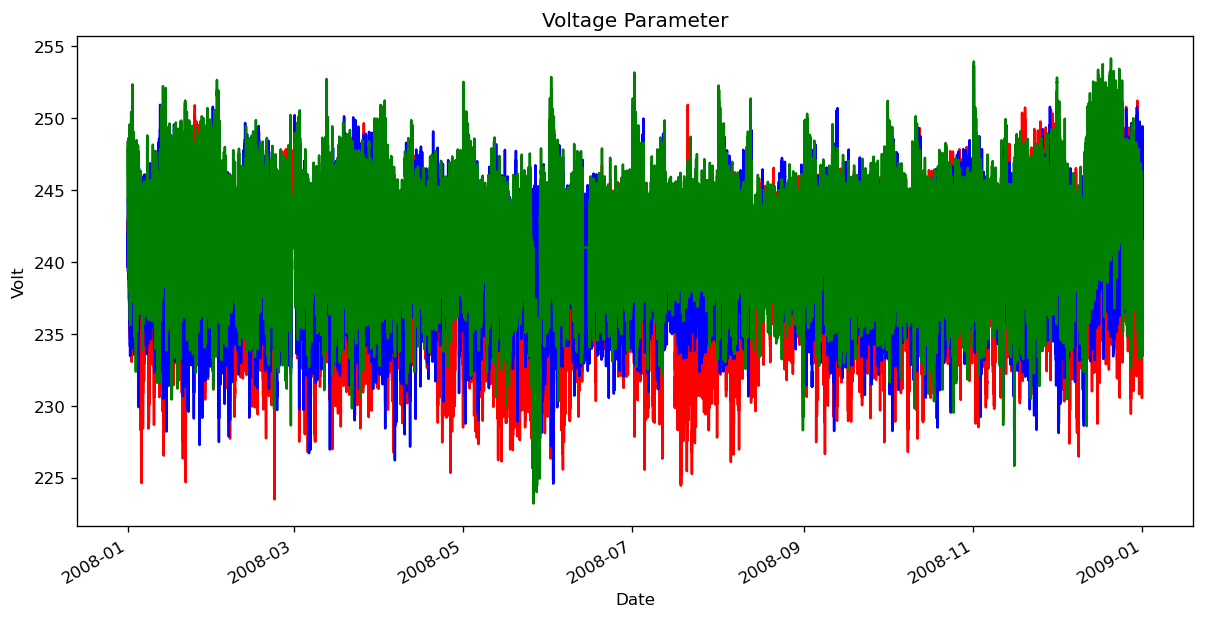

In [34]:
plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(12,6))

plt.subplot()
plt.title ('Voltage Parameter')
plt.xlabel ('Time')
plt.ylabel ('Volt')
V1.plot( color='r')
V2.plot( color='b')
V3.plot( color='green')

<AxesSubplot:title={'center':'Current Parameter'}, xlabel='Date', ylabel='Ampere'>

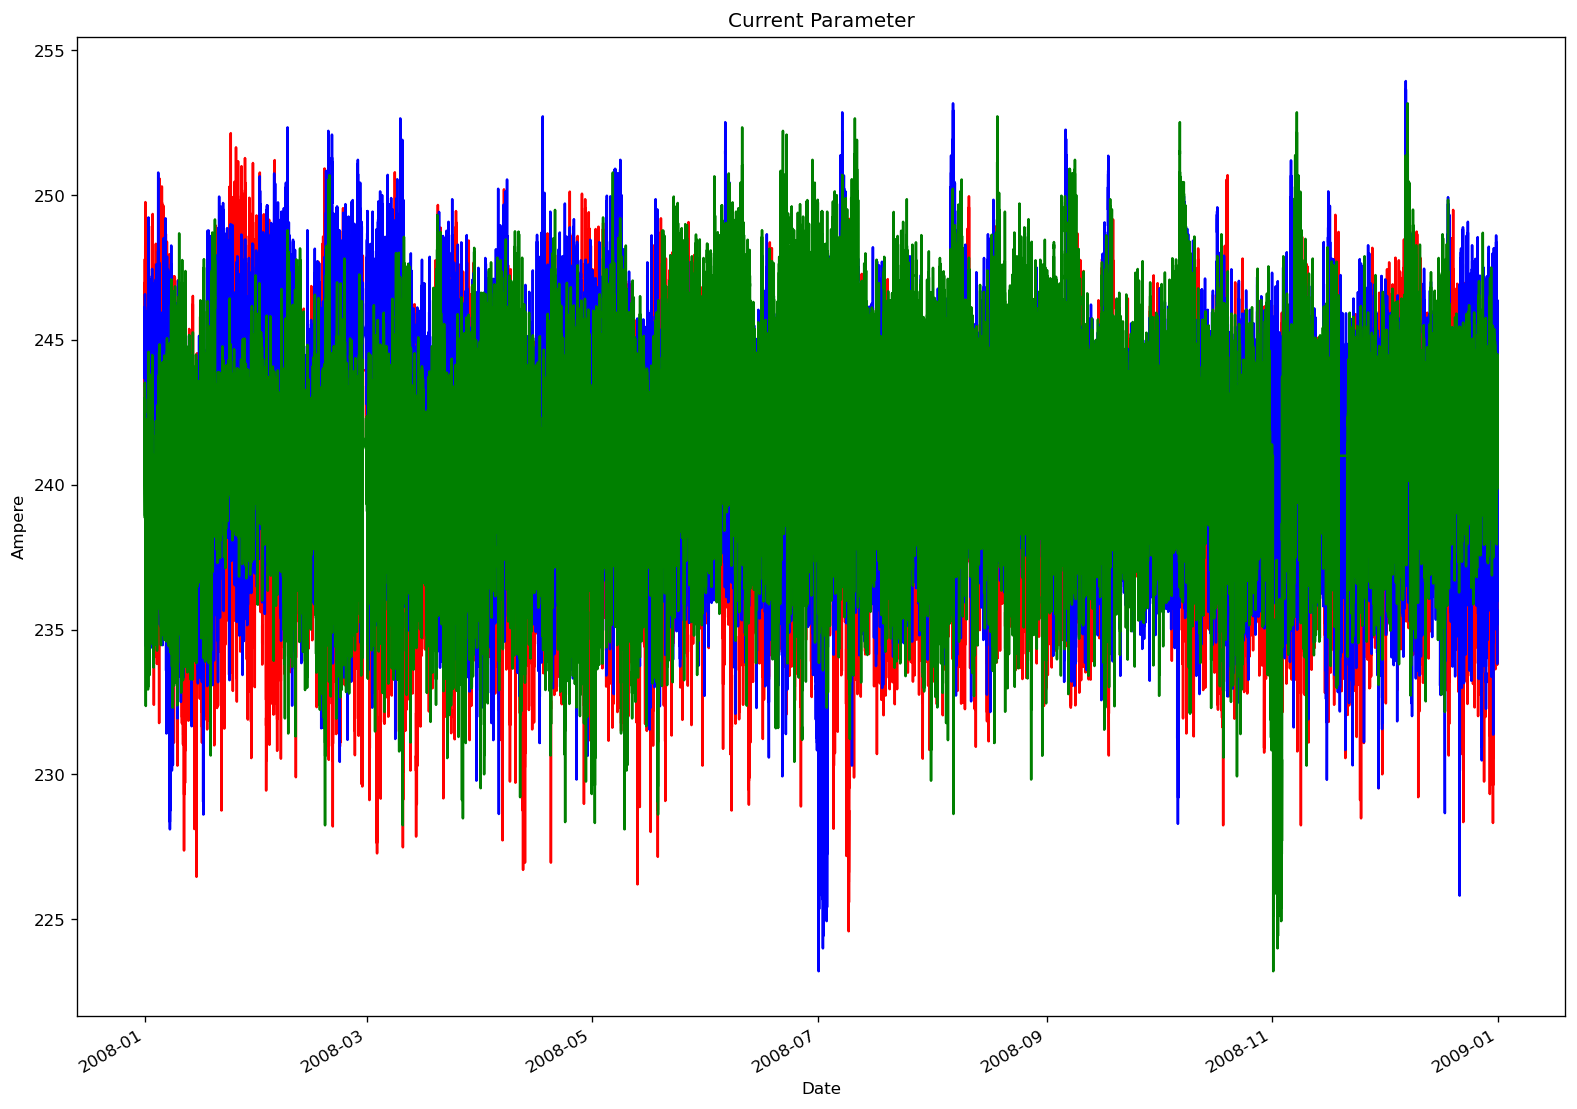

In [35]:
plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(16,12))

plt.subplot()
plt.title ('Current Parameter')
plt.xlabel ('Time')
plt.ylabel ('Ampere')
C1.plot( color='r')
C2.plot( color='b')
C3.plot( color='green')

In [36]:
normal = np.mean((V1+V2+V3)/3)
normal

240.63381021690185

In [37]:
max = np.max(V1)
if (np.max(V2)>max):
    max = np.max(V2)
if (np.max(V3)>max):
    max = np.max(V3)
    
min = np.min(V1)
if (np.min(V2)<min):
    min = np.min(V2)
if (np.min(V3)<min):
    min = np.min(V3)
min

223.2

In [38]:
rng = max-min
high_rng1 = (max-normal)*0.03+normal
low_rng1 = normal - ((normal-min)*0.03)
high_rng2 = (max-normal)*0.05+normal
low_rng2 = normal - ((normal-min)*0.05)

In [39]:
v = [V1, V2, V3]

In [40]:
a1 = 0
a2 = 0
a3 = 0
for n in v:
    for x in n:
        if(x >= high_rng2):
            a3 = a3 + 1
        if(x >= high_rng1 and x<high_rng2 ):
            a2 = a2 + 1
        if(x >= low_rng1 and x<high_rng1 ):
            a1 = a1 + 1
        if(x >= low_rng2 and x<low_rng1 ):
            a2 = a2 + 1
        if(x < low_rng2):
            a3 = a3 + 1

In [41]:
table = [['Range', 'Frequency'], ['<3%', a1],['3-5%', a2],['>5%', a3]]

In [42]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤═════════════╕
│ Range   │   Frequency │
╞═════════╪═════════════╡
│ <3%     │      199661 │
├─────────┼─────────────┤
│ 3-5%    │      127382 │
├─────────┼─────────────┤
│ >5%     │     1249757 │
╘═════════╧═════════════╛


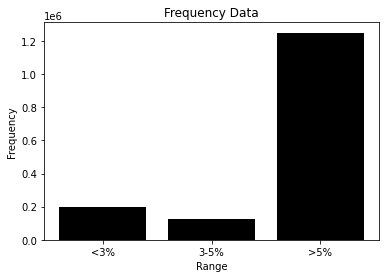

In [43]:
Range = ['<3%','3-5%','>5%']
Freq = [a1,a2,a3]
plt.bar(Range,Freq, color='black')
plt.title('Frequency Data')
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.show()

In [44]:
def Max_pvur(a,b,c):
    x = 0
    y = 0
    z = 0
    max = []
    for i in range(len(a)):
        x = a[i]-(a[i]+b[i]+c[i])/3
        y = b[i]-(a[i]+b[i]+c[i])/3
        z = c[i]-(a[i]+b[i]+c[i])/3
        
        m = [x,y,z]
        max.append(np.max(m))
        
    return max

def calc(a,b,c):
    n = (a+b+c)/3
    
    return n

In [45]:
max_pvur = Max_pvur(V1,V2,V3)

In [46]:
pvur = max_pvur/calc(V1,V2,V3) * 100

In [47]:
pvur

Date
2008-01-01 00:00:00    1.709799
2008-01-01 00:01:00    1.634277
2008-01-01 00:02:00    1.688306
2008-01-01 00:03:00    1.713581
2008-01-01 00:04:00    1.521131
                         ...   
2008-12-31 23:55:00    1.783439
2008-12-31 23:56:00    1.670183
2008-12-31 23:57:00    1.575095
2008-12-31 23:58:00    1.404048
2008-12-31 23:59:00    1.552948
Name: Voltage, Length: 525600, dtype: float64

In [48]:
pvur_df = V1_df.copy()
pvur_df['Voltage'] = pvur
PVUR = pvur_df['Voltage']

In [49]:
PVUR

Date
2008-01-01 00:00:00    1.709799
2008-01-01 00:01:00    1.634277
2008-01-01 00:02:00    1.688306
2008-01-01 00:03:00    1.713581
2008-01-01 00:04:00    1.521131
                         ...   
2008-12-31 23:55:00    1.783439
2008-12-31 23:56:00    1.670183
2008-12-31 23:57:00    1.575095
2008-12-31 23:58:00    1.404048
2008-12-31 23:59:00    1.552948
Name: Voltage, Length: 525600, dtype: float64

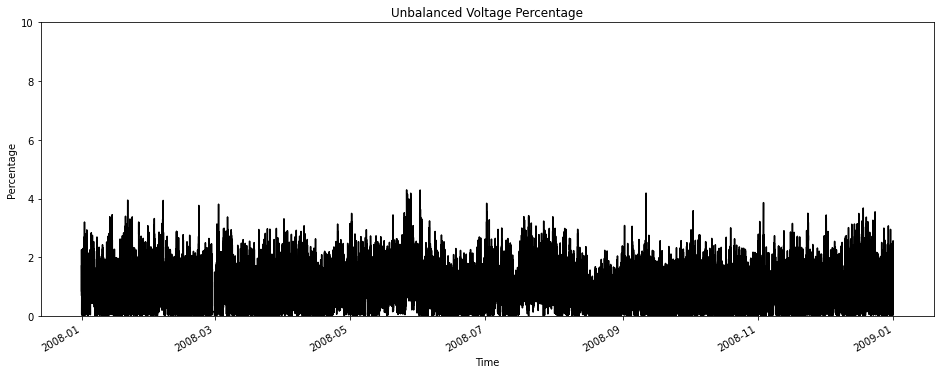

In [50]:
plt.figure(figsize = (16,6))
PVUR.plot( color='black')
plt.title('Unbalanced Voltage Percentage')
plt.ylabel('Percentage')
plt.xlabel('Time')
plt.ylim(0,10)
plt.show()

In [51]:
Rl = 1
Rn = 1
Rg = 1

In [52]:
def diff_loss(a,b,c,d):
    diff = []
    x = calc(a,b,c)
    balanced_load = 0
    unbalanced_load = 0
    for i in range(len(a)):
        balanced_load = ((x[i]**2*Rl)+(x[i]**2*Rn)+(x[i]**2*Rg))/1000
        unbalanced_load = ((a[i]**2*Rl)+(b[i]**2*Rn)+(c[i]**2*Rg))/1000
        
        diff.append(((unbalanced_load - balanced_load)*d[i])*1/60)
        
    return diff

In [53]:
def loss(a,b):
    diff = []
    for i in range(len(a)):
        cons = (a[i]*b[i]*np.sqrt(3)/1000)/60
        diff.append(cons)
        
    return diff

In [54]:
diff = diff_loss(C1,C2,C3,P)
diff_df = C1_df.copy()
diff_df['value'] = diff
Diff = diff_df['value']

In [55]:
loss = loss(calc(C1,C2,C3),calc(V1,V2,V3))
loss_df = C1_df.copy()
loss_df['value'] = loss
Loss = loss_df['value']

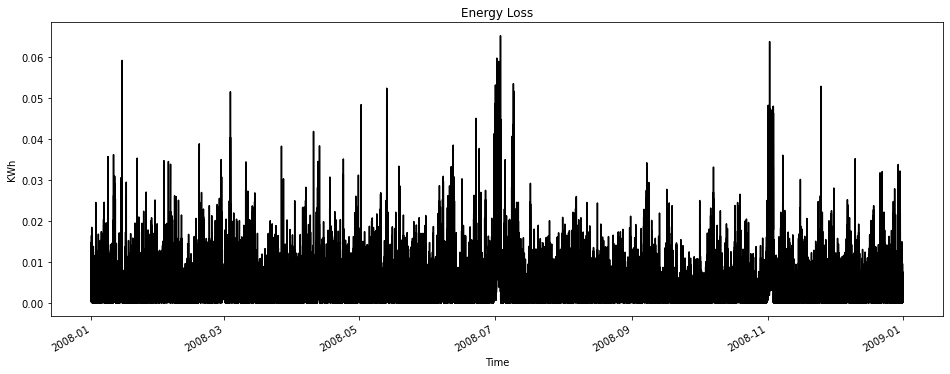

In [56]:
plt.figure(figsize = (16,6))
Diff.plot( color='black')
plt.title('Energy Loss')
plt.ylabel('KWh')
plt.xlabel('Time')
plt.show()

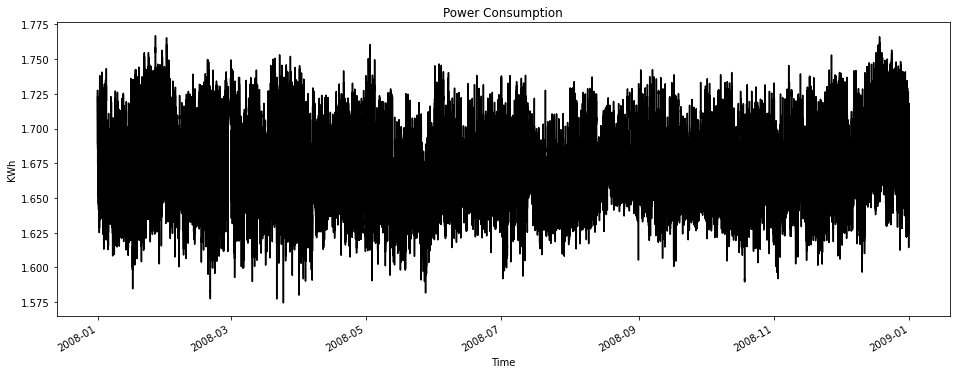

In [57]:
plt.figure(figsize = (16,6))
Loss.plot( color='black')
plt.title('Power Consumption')
plt.ylabel('KWh')
plt.xlabel('Time')
plt.show()

In [58]:
Loss.sum()

880784.6058322577

In [59]:
Diff_day = []
for i in range(365):
    y = np.sum(Diff[1440*i:1440*(i+1)])
    Diff_day.append(y)

In [60]:
Loss_day = []
for i in range(365):
    y = np.sum(Loss[1440*i:1440*(i+1)])
    Loss_day.append(y)

In [61]:
dti2 = pd.date_range("2008-01-01", periods=365, freq="D")
Diff_day = pd.Series(Diff_day, index = dti2)
Loss_day = pd.Series(Loss_day, index = dti2)

In [62]:
Diff_day

2008-01-01    4.501520
2008-01-02    3.330174
2008-01-03    4.860385
2008-01-04    4.646121
2008-01-05    3.803993
                ...   
2008-12-26    4.331520
2008-12-27    4.152580
2008-12-28    5.892854
2008-12-29    6.544076
2008-12-30    3.038697
Freq: D, Length: 365, dtype: float64

In [63]:
Loss_day

2008-01-01    2416.672670
2008-01-02    2424.392857
2008-01-03    2408.238736
2008-01-04    2429.546584
2008-01-05    2399.805001
                 ...     
2008-12-26    2431.430116
2008-12-27    2440.282741
2008-12-28    2438.248785
2008-12-29    2430.116962
2008-12-30    2424.483086
Freq: D, Length: 365, dtype: float64

In [64]:
Loss_day[Loss_day < 10]

Series([], Freq: D, dtype: float64)

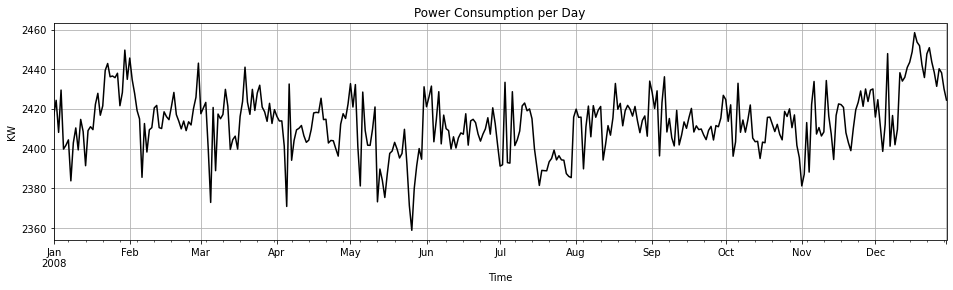

Power Consumption in a year is: 880784.61 KW


In [65]:
plt.figure(figsize = (16,4))
Loss_day.plot( color='black')
plt.title('Power Consumption per Day')
plt.ylabel('KW')
plt.xlabel('Time')
plt.grid()
plt.show()
print('Power Consumption in a year is:', round(np.sum(Loss_day),2), 'KW')

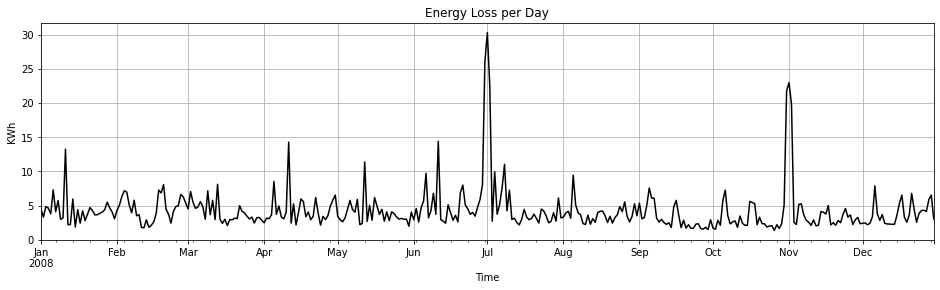

Total Energy Loss in a year is: 1562.26 KWh
Percentage of the Energy Loss and Total Power Consumption in a year is: 0.18 %


In [66]:
plt.figure(figsize = (16,4))
Diff_day.plot( color='black')
plt.title('Energy Loss per Day')
plt.ylabel('KWh')
plt.xlabel('Time')
plt.grid()
plt.show()
print('Total Energy Loss in a year is:', round(np.sum(Diff_day),2), 'KWh')
print('Percentage of the Energy Loss and Total Power Consumption in a year is:', round((np.sum(Diff_day)/np.sum(Loss_day)*100),2), '%')

In [67]:
from fbprophet import Prophet

In [68]:
model2 = Prophet(yearly_seasonality=12, daily_seasonality=True, seasonality_mode='additive')

In [69]:
def fill_array(len, value):
    x = []
    for i in range(len):
        x.append(value)
        
    return x

In [70]:
Loss_df = pd.DataFrame({'ds':fill_array(365, 0), 'y':Loss_day.copy()})

In [71]:
Loss_df['ds']=Loss_day.index

In [72]:
Loss_df.reset_index(drop=True, inplace=True)

In [73]:
Loss_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [74]:
Loss_df['ds'] = pd.to_datetime(Loss_df['ds'])

In [75]:
model2.fit(Loss_df)

In [76]:
future2 = model2.make_future_dataframe(periods=30, freq='D')

In [77]:
pred2 = model2.predict(future2)

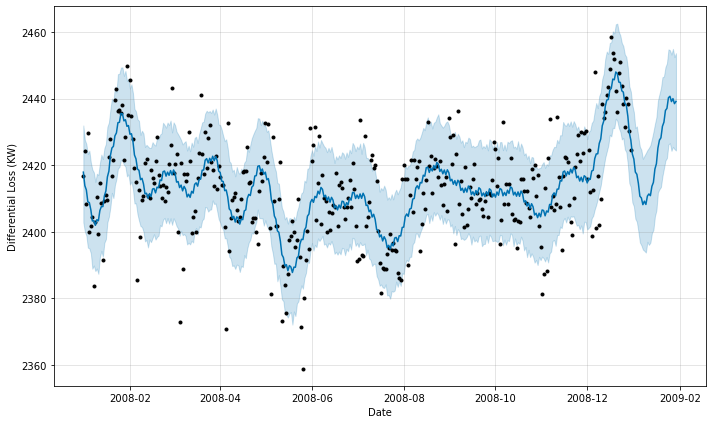

Total Power Consumption by forecasting in the next month is: 72698.47 KW


In [78]:
fig = model2.plot(pred2)
plt.xlabel('Date')
plt.ylabel('Differential Loss (KW)')
plt.show()

print('Total Power Consumption by forecasting in the next month is:', round(np.sum(pred2['yhat'][-30:]),2), 'KW')

In [79]:
Diff_df = pd.DataFrame({'ds':fill_array(365, 0), 'y':Diff_day.copy()})

In [80]:
Diff_df['ds']=Diff_day.index

In [81]:
Diff_df.reset_index(drop=True, inplace=True)

In [82]:
Diff_df['ds'] = pd.to_datetime(Diff_df['ds'])

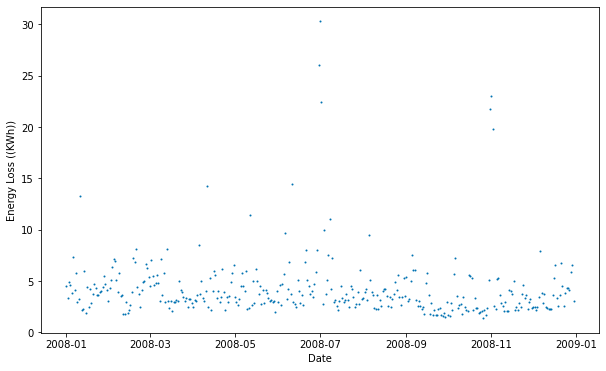

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(Diff_df['ds'], Diff_df['y'], s=1, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Energy Loss ((KWh))')
plt.show()

In [84]:
model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')

In [85]:
model.fit(Diff_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [86]:
future = model.make_future_dataframe(periods=30, freq='D')

In [87]:
pred = model.predict(future)

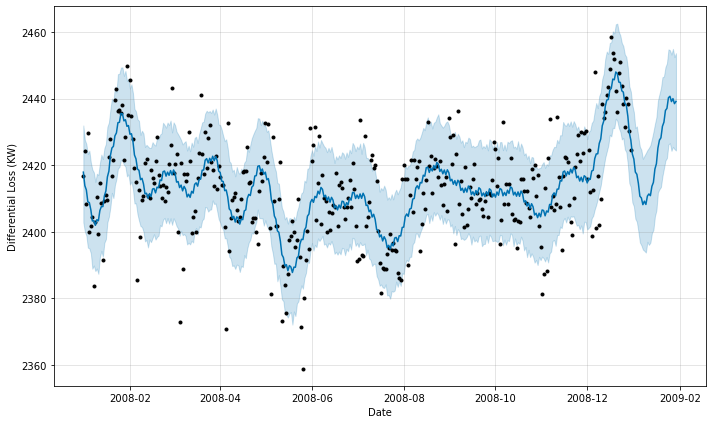

Total Power Consumption by forecasting in the next month is: 72698.47 KW


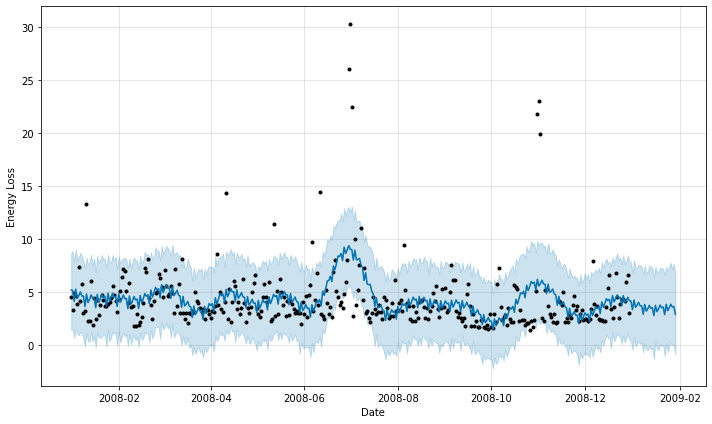

Total Energy Loss by forecasting in the next month is: 105.32 KWh
Percentage of the Energy Loss and Total Power Consumption in the next month is: 0.14 %


In [88]:
fig = model2.plot(pred2)
plt.xlabel('Date')
plt.ylabel('Differential Loss (KW)')
plt.show()

print('Total Power Consumption by forecasting in the next month is:', round(np.sum(pred2['yhat'][-30:]),2), 'KW')

fig = model.plot(pred)
plt.xlabel('Date')
plt.ylabel('Energy Loss')
plt.show()

print('Total Energy Loss by forecasting in the next month is:', round(np.sum(pred['yhat'][-30:]),2), 'KWh')

print('Percentage of the Energy Loss and Total Power Consumption in the next month is:', round((np.sum(pred['yhat'][-30:])/np.sum(pred2['yhat'][-30:])*100),2), '%')

C:\Users\lenovo\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\lenovo\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


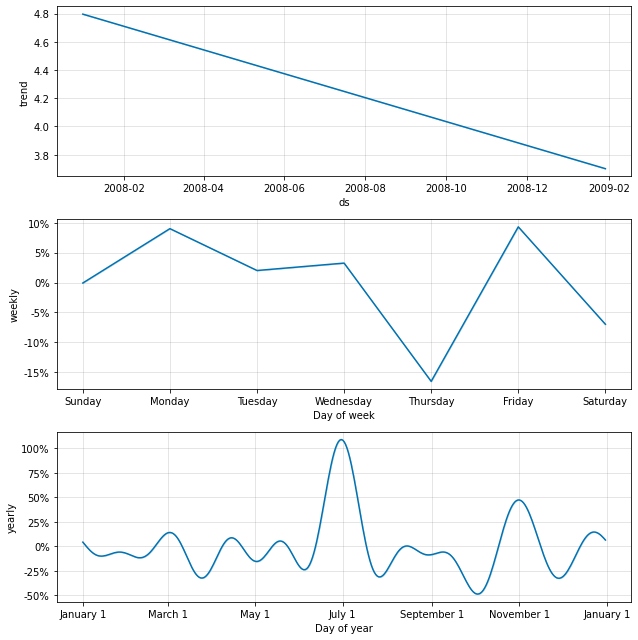

In [89]:
fig2 = model.plot_components(pred)
plt.show()

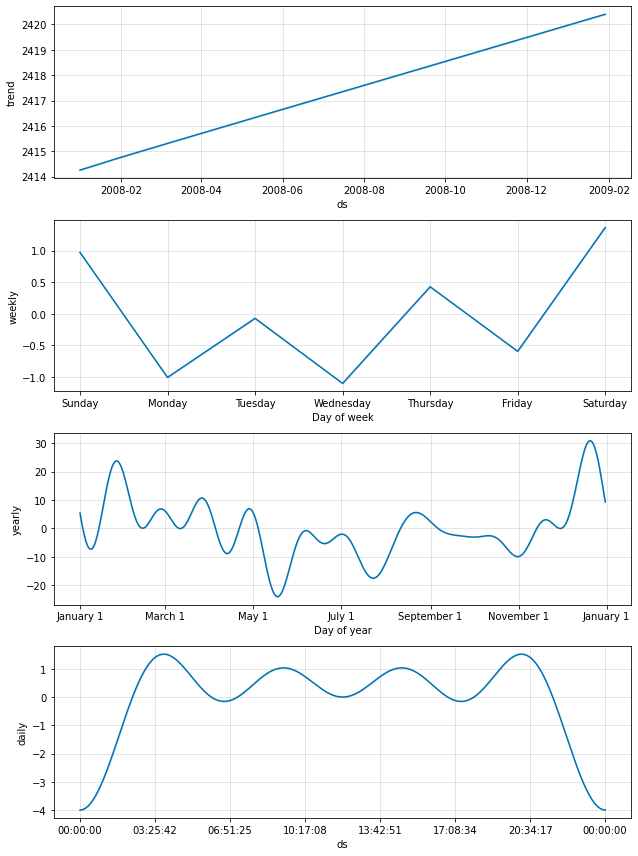

In [90]:
fig2 = model2.plot_components(pred2)
plt.show()

In [91]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
   # error = y - predictions
    #mfe = np.sqrt(np.mean(predictions**2))
    #mse = np.sqrt(np.mean(y**2))
    #rmse = np.sqrt(np.mean(error**2))
    #theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    #print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [92]:
print('Performansi Model Forecasting Energy Loss:')
print('')
model_eval(pred['yhat'][-60:-30], Diff_df['y'][-30:])

Performansi Model Forecasting Energy Loss:

Mean Absolute Error: 1.105
Mean Squared Error: 2.255
Root Mean Squared Error: 1.502
Mean absolute percentage error: 29.789
Scaled Mean absolute percentage error: 27.927
Mean forecast error: -0.014
Normalised mean squared error: 5.137


In [93]:
print('Performansi Model Forecasting Power Consumption:')
print('')
model_eval(pred2['yhat'][:-30], Loss_df['y'])

Performansi Model Forecasting Power Consumption:

Mean Absolute Error: 8.576
Mean Squared Error: 124.803
Root Mean Squared Error: 11.172
Mean absolute percentage error: 0.356
Scaled Mean absolute percentage error: 0.356
Mean forecast error: 0.0
Normalised mean squared error: 1.151


In [94]:
def MAPE(y, prediction):
    mape = np.mean(np.abs((y - prediction) / y)) * 100
    
    return mape

In [95]:
Diff

Date
2008-01-01 00:00:00    0.002405
2008-01-01 00:01:00    0.001373
2008-01-01 00:02:00    0.000851
2008-01-01 00:03:00    0.002195
2008-01-01 00:04:00    0.002000
                         ...   
2008-12-31 23:55:00    0.000514
2008-12-31 23:56:00    0.000642
2008-12-31 23:57:00    0.000738
2008-12-31 23:58:00    0.000607
2008-12-31 23:59:00    0.000331
Name: value, Length: 525600, dtype: float64

# Normalize dataframe

In [96]:
df_day = Diff_day/np.max(Diff_day)
df_loss = Loss_day/np.max(Loss_day)

In [97]:
df_day

2008-01-01    0.148622
2008-01-02    0.109949
2008-01-03    0.160471
2008-01-04    0.153397
2008-01-05    0.125593
                ...   
2008-12-26    0.143010
2008-12-27    0.137102
2008-12-28    0.194559
2008-12-29    0.216060
2008-12-30    0.100326
Freq: D, Length: 365, dtype: float64

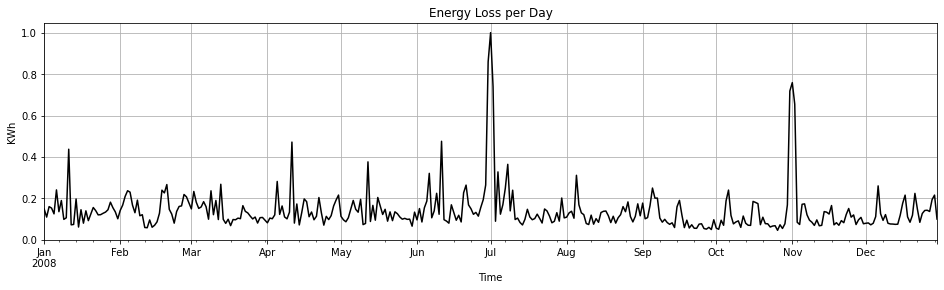

In [98]:
plt.figure(figsize = (16,4))
df_day.plot( color='black')
plt.title('Energy Loss per Day')
plt.ylabel('KWh')
plt.xlabel('Time')
plt.grid()
plt.show()

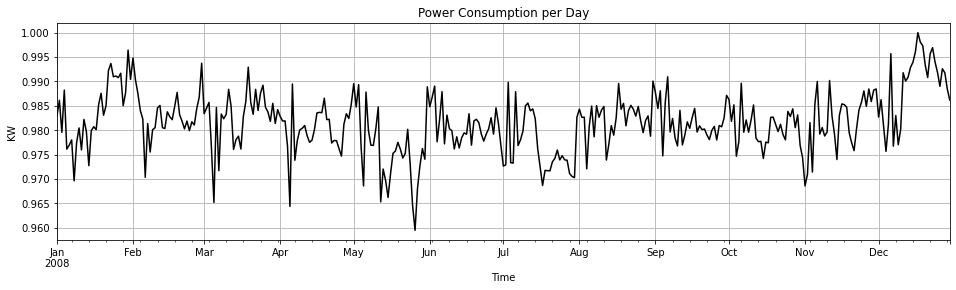

In [99]:
plt.figure(figsize = (16,4))
df_loss.plot( color='black')
plt.title('Power Consumption per Day')
plt.ylabel('KW')
plt.xlabel('Time')
plt.grid()
plt.show()

In [100]:
nobs = 30  #jumlah data yang dibandingkan dengan data aktual
def train(series1):
    df_train, df_test = series1[0:-nobs], series1[-nobs:]
    
    # Check size
    print(df_train.shape)  # (7746, 1)
    print(df_test.shape)  # (30, 1)
    
    return df_train, df_test

In [101]:
df_train, df_test = train (df_day)
dfloss_train, dfloss_test = train (df_loss)

(335,)
(30,)
(335,)
(30,)


<Figure size 1296x720 with 0 Axes>

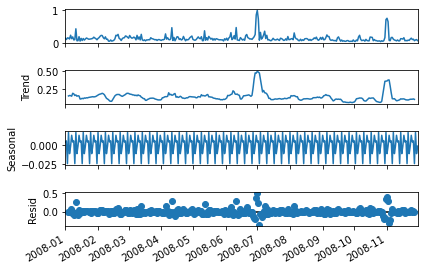

In [104]:
#Mengecek seasonalitas data dan dekomposisi trend dan seasonal data pada VibrationX dengan model dekomposisi additive
result_add = seasonal_decompose(df_train, model='add')

#Plot hasil dekomposisi
plt.figure(figsize=(18,10))
result_add.plot()
plt.tight_layout();
plt.gcf().autofmt_xdate()


#Mengecek seasonalitas data dengan model dekomposisi multiplicative tidak bisa dengan data yang memiliki nilai negatif

<Figure size 1296x720 with 0 Axes>

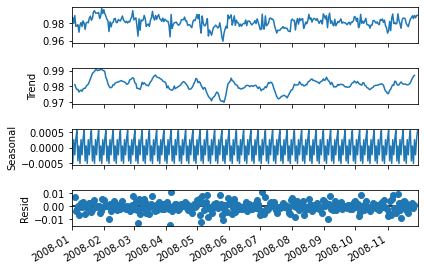

In [105]:
#Mengecek seasonalitas data dan dekomposisi trend dan seasonal data pada VibrationX dengan model dekomposisi additive
result_add = seasonal_decompose(dfloss_train, model='add')

#Plot hasil dekomposisi
plt.figure(figsize=(18,10))
result_add.plot()
plt.tight_layout();
plt.gcf().autofmt_xdate()


#Mengecek seasonalitas data dengan model dekomposisi multiplicative tidak bisa dengan data yang memiliki nilai negatif

In [106]:
#Pembentukan model Holt-Winters-Exponential-Smoothing dengan model additive (trend dan seasonal)
Mape = 100
n = 0
for i in range (int(len(df_train)/2)-2):
    model = HWES(df_train,seasonal_periods = i+2, trend='add', seasonal='add', freq = 'D')
    fitted = model.fit()
    temp_forecast = fitted.forecast(nobs) 
    temp_predict = fitted.predict(300)
    a = MAPE(df_test, temp_forecast)
    if a<Mape:
        Mape = a
        n = i+2

print('MAPE =', Mape)
print('n =', n)
model = HWES(df_train,seasonal_periods = n, trend='add', seasonal='add', freq = 'D')
fitted = model.fit()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


MAPE = 26.983902828111926
n = 10


In [107]:
#forecasting the data from 'nobs' data before the final data and forecast for the next 3 years
temp_forecast = fitted.forecast(nobs) #want to forecast for the next 3 years
temp_predict = fitted.predict(300) #predict from the series[1200]
temp_predict

2008-10-27    0.052054
2008-10-28    0.077302
2008-10-29    0.070030
2008-10-30    0.049730
2008-10-31    0.114470
2008-11-01    0.531499
2008-11-02    0.665947
2008-11-03    0.658391
2008-11-04    0.290820
2008-11-05    0.156617
2008-11-06    0.161960
2008-11-07    0.181405
2008-11-08    0.149292
2008-11-09    0.088880
2008-11-10    0.073809
2008-11-11    0.095976
2008-11-12    0.083035
2008-11-13    0.072836
2008-11-14    0.075920
2008-11-15    0.121702
2008-11-16    0.125035
2008-11-17    0.136533
2008-11-18    0.162685
2008-11-19    0.078781
2008-11-20    0.068768
2008-11-21    0.094671
2008-11-22    0.080403
2008-11-23    0.081511
2008-11-24    0.113126
2008-11-25    0.144456
2008-11-26    0.117351
2008-11-27    0.131074
2008-11-28    0.101228
2008-11-29    0.072984
2008-11-30    0.083457
Freq: D, dtype: float64

In [108]:
#Pembentukan model Holt-Winters-Exponential-Smoothing dengan model additive (trend dan seasonal)
Mape = 100
n = 0
for i in range (int(len(dfloss_train)/2)-2):
    model = HWES(dfloss_train,seasonal_periods = i+2, trend='add', seasonal='add', freq = 'D')
    fitted = model.fit()
    temp_forecast2 = fitted.forecast(nobs) 
    temp_predict2 = fitted.predict(300)
    a = MAPE(dfloss_test, temp_forecast2)
    if a<Mape:
        Mape = a
        n = i+2

print('MAPE =', Mape)
print('n =', n)
model2 = HWES(dfloss_train,seasonal_periods = n, trend='add', seasonal='add', freq = 'D')
fitted2 = model2.fit()

MAPE = 0.4182813006612195
n = 66


In [109]:
#forecasting the data from 'nobs' data before the final data and forecast for the next 3 years
temp_forecast2 = fitted2.forecast(nobs) #want to forecast for the next 3 years
temp_predict2 = fitted2.predict(300) #predict from the series[1200]
temp_predict2

2008-10-27    0.980408
2008-10-28    0.981897
2008-10-29    0.981407
2008-10-30    0.982742
2008-10-31    0.979702
2008-11-01    0.976101
2008-11-02    0.973575
2008-11-03    0.974725
2008-11-04    0.974211
2008-11-05    0.979161
2008-11-06    0.980508
2008-11-07    0.982926
2008-11-08    0.982173
2008-11-09    0.977818
2008-11-10    0.978544
2008-11-11    0.983308
2008-11-12    0.986125
2008-11-13    0.981390
2008-11-14    0.978786
2008-11-15    0.982283
2008-11-16    0.981266
2008-11-17    0.983464
2008-11-18    0.982840
2008-11-19    0.983994
2008-11-20    0.983228
2008-11-21    0.979136
2008-11-22    0.978683
2008-11-23    0.976931
2008-11-24    0.977922
2008-11-25    0.985743
2008-11-26    0.979322
2008-11-27    0.986275
2008-11-28    0.984951
2008-11-29    0.987146
2008-11-30    0.987684
Freq: D, dtype: float64

In [128]:
df_train = df_train*np.max(Diff_day)
temp_forecast = temp_forecast*np.max(Diff_day)
temp_predict = temp_predict*np.max(Diff_day)
df_test = df_test*np.max(Diff_day)

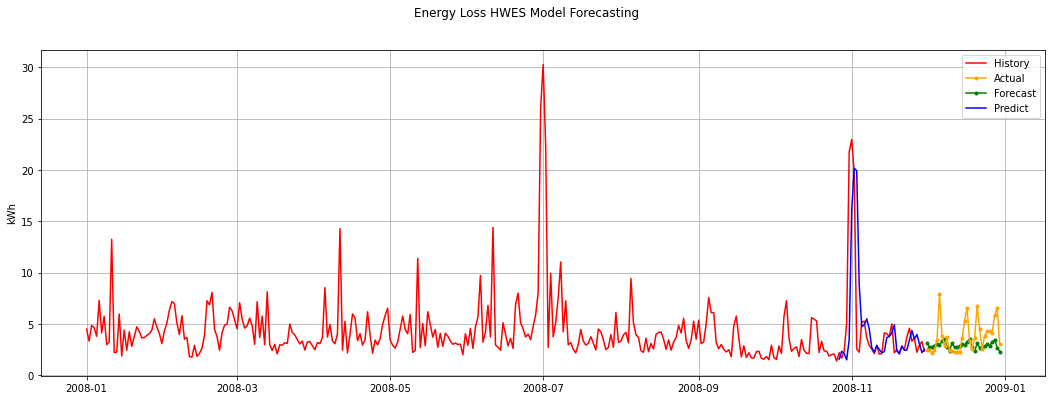

In [131]:
fig = plt.figure(figsize = (18,6))
fig.suptitle('Energy Loss HWES Model Forecasting')
past, = plt.plot(df_train.index, df_train, 'r-', label='History')
forecasted_future, = plt.plot( temp_forecast, 'g.-', label='Forecast')
predicted_past, = plt.plot(temp_predict, 'b-', label='Predict')
future, = plt.plot(df_test.index, df_test, color = 'orange', marker = '.', label='Actual')
plt.legend(handles=[past, future, forecasted_future, predicted_past])
plt.ylabel('kWh')
plt.grid()
plt.show()

In [111]:
model_eval(df_test, temp_forecast)

Mean Absolute Error: 0.04
Mean Squared Error: 0.003
Root Mean Squared Error: 0.057
Mean absolute percentage error: 26.984
Scaled Mean absolute percentage error: 31.497
Mean forecast error: 0.029
Normalised mean squared error: 1.207


In [132]:
dfloss_train = dfloss_train*np.max(Loss_day)
temp_forecast2 = temp_forecast2*np.max(Loss_day)
temp_predict2 = temp_predict2*np.max(Loss_day)
dfloss_test = dfloss_test*np.max(Loss_day)

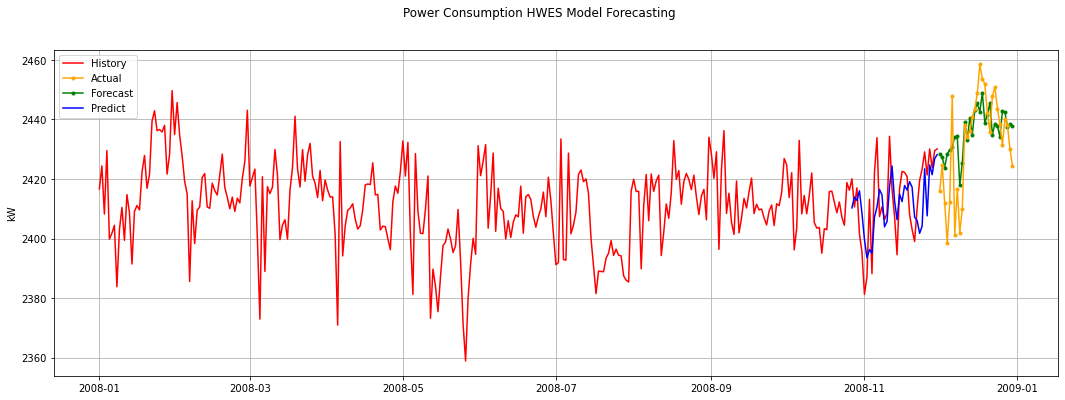

In [134]:
fig = plt.figure(figsize = (18,6))
fig.suptitle('Power Consumption HWES Model Forecasting')
past, = plt.plot(dfloss_train.index, dfloss_train, 'r-', label='History')
forecasted_future, = plt.plot(temp_forecast2, 'g.-', label='Forecast')
predicted_past, = plt.plot(temp_predict2, 'b-', label='Predict')
future, = plt.plot(dfloss_test.index, dfloss_test, color = 'orange', marker = '.', label='Actual')
plt.legend(handles=[past, future, forecasted_future, predicted_past])
plt.ylabel('kW')
plt.grid()
plt.show()

In [113]:
model_eval(dfloss_test, temp_forecast2)

Mean Absolute Error: 0.004
Mean Squared Error: 0.0
Root Mean Squared Error: 0.005
Mean absolute percentage error: 0.418
Scaled Mean absolute percentage error: 0.417
Mean forecast error: -0.001
Normalised mean squared error: 0.592


# SARIMA Model

## Remove the trend

In [114]:
first_diff = df_day.diff()[1:]

In [115]:
start_date = df_day.index[0]
end_date = df_day.index[-1]

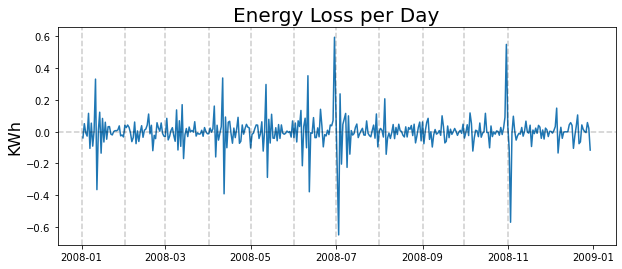

In [116]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Energy Loss per Day', fontsize=20)
plt.ylabel('KWh', fontsize=16)
for month in range(start_date.month,end_date.month):
    plt.axvline(pd.to_datetime('2008-'+str(month)+'-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [117]:
first_diff

2008-01-02   -0.038673
2008-01-03    0.050522
2008-01-04   -0.007074
2008-01-05   -0.027804
2008-01-06    0.115569
                ...   
2008-12-26    0.001123
2008-12-27   -0.005908
2008-12-28    0.057457
2008-12-29    0.021501
2008-12-30   -0.115734
Freq: D, Length: 364, dtype: float64

## ACF

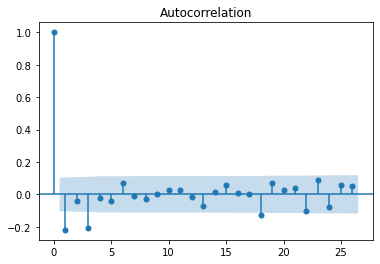

In [118]:
acf_plot = plot_acf(first_diff)

## PACF

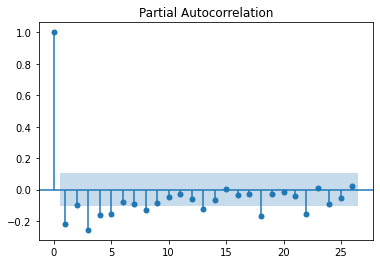

In [119]:
pacf_vals = plot_pacf(first_diff)

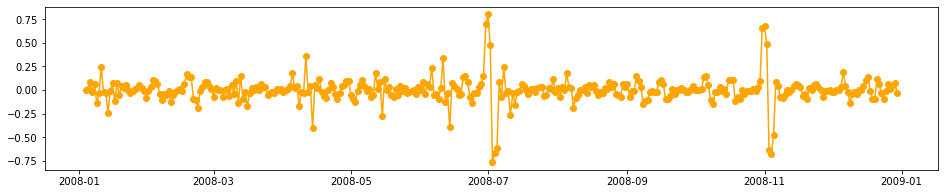

In [120]:
prices = df_day
price_diff = prices.diff(3).dropna() 

plt.figure(figsize=(16,3))
plt.plot(price_diff, "-o", color='orange')

In [121]:
time_series = price_diff.values

In [122]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 90
X, y = organize_data(time_series, lag)

MAE = 0.055
MAE2 = 0.051


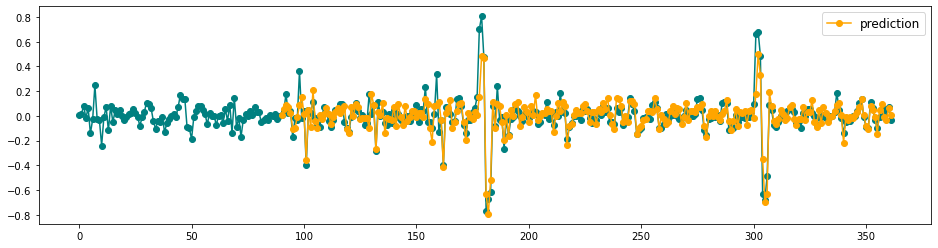

In [123]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', color='teal')
plt.plot(np.arange(lag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], lr_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], lr_prediction[-90:]))) #for the last 90 days only

In [124]:
df_day

2008-01-01    0.148622
2008-01-02    0.109949
2008-01-03    0.160471
2008-01-04    0.153397
2008-01-05    0.125593
                ...   
2008-12-26    0.143010
2008-12-27    0.137102
2008-12-28    0.194559
2008-12-29    0.216060
2008-12-30    0.100326
Freq: D, Length: 365, dtype: float64

In [125]:
train_end = datetime.datetime(2008,11,30)
test_end = datetime.datetime(2008,12,30)

train_data = Loss_day[:train_end]
test_data = Loss_day[train_end + datetime.timedelta(days=1):test_end]

# Fit the SARIMA Model

In [126]:
my_order = (1,1,1)
my_seasonal_order = (3, 0, 2, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [127]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

NameError: name 'time' is not defined

In [ ]:
#summary of the model
print(model_fit.summary())

In [ ]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(df_day)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
import itertools

# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
seasonal_pdq

In [ ]:
pdq

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            print('haai')
            continue

In [ ]:
SARIMAX_model

In [ ]:
AIC

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(np.min(AIC), SARIMAX_model[AIC.index(np.min(AIC))][0],SARIMAX_model[AIC.index(np.min(AIC))][1]))

In [ ]:
SARIMAX_model[AIC.index(np.min(AIC))][0]

In [ ]:
SARIMAX_model[AIC.index(np.min(AIC))][1]

In [ ]:
# Let's fit this model
mod = SARIMAX(train_data,
              order=(3, 1, 1),
              seasonal_order=(1, 0, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
results.summary()

In [ ]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [ ]:
pred0 = results.get_prediction(start='2008-09-30', dynamic=False)
pred0_ci = pred0.conf_int()

In [ ]:
pred1 = results.get_prediction(start='2008-09-30', dynamic=True)
pred1_ci = pred1.conf_int()

In [ ]:
pred2 = results.get_forecast('2009-01-30')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2008-11-30':'2008-12-30'])

In [ ]:
ax = df_day.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
pred1_ci

In [ ]:
pred1.predicted_mean.plot(label='1-step-ahead Forecast (get_predictions, dynamic=False)')

In [ ]:
X = df_day.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [ ]:
df_day

In [ ]:
from auto_ts import auto_timeseries

model = auto_timeseries( score_type='rmse', time_interval='D', non_seasonal_pdq=None, seasonality=False, seasonal_period=12, model_type=['Prophet'], verbose=2)

In [ ]:
model.fit( traindata=Loss_df, ts_column="ds", target="y", cv=5)

In [ ]:
Diff_df